In [1]:
import os
import numpy as np
import dlib
import cv2
from scipy.misc import *
import matplotlib.pyplot as plt
from glob import glob
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import itertools
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import cross_val_score
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
CLASS2LBL = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
LBL2CLASS = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

def parse_lbl(fname):
    _class = fname.split('/')[-2]
    return CLASS2LBL[_class]

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(15, 10))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
        print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig('confusion_release.png')

## 1. Соберем лица и лендмарки

In [5]:
DATA_PATH = '/home/_datasets_/emotiw2017/'
TRAIN_DIR = 'train'
VAL_DIR = 'val'
TEST_DIR = 'test'
IMG_TMPL = '*.jpg'
PREDICTOR_PATH = '/home/arassadin/distr/shape_predictor_68_face_landmarks.dat'
OUT_SIZE = (224, 224)

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)
face_cascade = cv2.CascadeClassifier('/home/arassadin/distr/opencv/data/haarcascades_GPU/haarcascade_frontalface_alt2.xml')

In [7]:
files_train = glob(os.path.join(DATA_PATH, TRAIN_DIR, '*', '*'))
files_val = glob(os.path.join(DATA_PATH, VAL_DIR, '*', '*'))
files_test = glob(os.path.join(DATA_PATH, TEST_DIR, '*'))

print len(files_train), len(files_val), len(files_test)

3630 2065 772


In [8]:
def find_faces_dlib(img):
    try:
        rects = detector(img, 1)
    except:
        return None
    faces = []

    for rect in rects:
        y1 = rect.top()
        if y1 < 0:
            y1 = 0
        y2 = rect.bottom()
        if y2 > img.shape[0]:
            y2 = img.shape[0]
        x1 = rect.left()
        if x1 < 0:
            x1 = 0
        x2 = rect.right()
        if x2 > img.shape[1]:
            x2 = img.shape[1]
        faces.append(img[y1:y2, x1:x2])
    
    return faces

In [9]:
def find_faces_ocv(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dets = face_cascade.detectMultiScale(gray, 1.3, 4)
    faces = [img[y : y + h, x : x + w] for x, y, w, h in dets]        
    return faces

In [10]:
def get_dst(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt(np.square(y2 - y1) + np.square(x2 - x1))

In [11]:
def find_landmarks(face):
    bbox = dlib.rectangle(0, 0, face.shape[1] - 1, face.shape[0] - 1)
    shape = predictor(face, bbox)
    landmarks = [(shape.part(i).x, shape.part(i).y) for i in range(68)]
    leftmost = min([l[0] for l in landmarks])
    topmost = min([l[1] for l in landmarks])
    landmarks = [(l[0] - leftmost, l[1] - topmost) for l in landmarks]
    dsts = []
    for i in range(68):
        for j in range(i + 1, 68):
            dsts.append(get_dst(landmarks[i], landmarks[j]))
    dsts = np.asarray(dsts)
    dsts /= dsts.max()
    return dsts

In [12]:
if not os.path.exists('./data'):
    os.makedirs('./data')

fault_counter = 0
def routine(files):
    global fault_counter
    data_faces, data_dsts = {}, {}
    for fname in log_progress(files):
        img = imread(fname, mode='RGB')
        faces = find_faces_dlib(img)
        if faces is None:
            print 'Something wrong with image {}!'.format(fname)
            continue
        if len(faces) == 0:
            faces = find_faces_ocv(img)
            if len(faces) == 0:
                fault_counter += 1
                continue

        faces = [imresize(f, OUT_SIZE) for f in faces]
        dsts = [find_landmarks(f) for f in faces]
        
        data_faces[fname] = faces
        data_dsts[fname] = dsts
    return data_faces, data_dsts

faces_train, dsts_train = routine(files_train)
# np.save('data/faces_train', faces_train); 
np.save('data/dsts_train_sized', dsts_train)
print len(files_train), len(faces_train), len(dsts_train)

faces_val, dsts_val = routine(files_val)
# np.save('data/faces_val', faces_val); 
np.save('data/dsts_val_sized', dsts_val)
print len(files_val), len(faces_val), len(dsts_val)

faces_test, dsts_test = routine(files_test[14:])
# np.save('data/faces_test', faces_test); 
np.save('data/dsts_test_sized', dsts_test)
print len(files_test), len(faces_test), len(dsts_test)

print 'No faces found on {} photos'.format(fault_counter)

3630 3553 3553


2065 2020 2020


Something wrong with image /home/_datasets_/emotiw2017/test/1997_Convocation.jpg!
Something wrong with image /home/_datasets_/emotiw2017/test/2011Fall_Convocation.jpg!
772 715 715
No faces found on 163 photos


In [56]:
y_train = {}
for fname in files_train:
    y_train[fname] = parse_lbl(fname)
    
y_val = {}
for fname in files_val:
    y_val[fname] = parse_lbl(fname)
    
print np.unique(y_train.values())
print np.unique(y_val.values())

np.save('data/y_train', y_train)
np.save('data/y_val', y_val)

[0 1 2]
[0 1 2]


## 2. Сбор нейросетевых скорингов

In [5]:
def normalize_vggface_1(arr):
    arr = arr[::-1, :, :].astype(np.float32)

    arr[0, :, :] -= 93.5940
    arr[1, :, :] -= 104.7624
    arr[2, :, :] -= 129.1863

    return arr

In [6]:
def normalize_vggface_2(arr):
    arr = arr[:, :, :].astype(np.float32)

    arr[0, :, :] -= 93.5940
    arr[1, :, :] -= 104.7624
    arr[2, :, :] -= 129.1863

    return arr

In [7]:
def normalize_vggface_3(arr):
    arr = arr[::-1, :, :].astype(np.float32)

    arr[0, :, :] -= 93.5940
    arr[1, :, :] -= 104.7624
    arr[2, :, :] -= 129.1863
    
    arr = arr[::-1, :, :]

    return arr

In [8]:
def routine1(data, model, norm_f):
    scores = {}
    for fname in log_progress(data.keys()):
#         _class = fname.split('/')[-2]
#         lbl = CLASS2LBL[_class]
#         scores_y.append(lbl)
        
        if len(data[fname]) < 1:
            continue
        faces = np.asarray([norm_f(np.moveaxis(face, 2, 0)) for face in data[fname]])
        preds = model.predict(faces)
        scores[fname] = np.median(preds, axis=0)
        # break
    return scores

def routine2(fname, model, m='default'):
    data = np.load(fname).item()
    for i, norm_f in zip([1, 3], [normalize_vggface_1, normalize_vggface_3]):
        scores = routine1(data, model, norm_f)
        postfix = os.path.basename(fname).split('_')[-1]
        np.save('data/scores_{}_norm={}_model={}'.format(postfix, i, m), scores)

model = VGGFace(include_top=False, input_shape=(3, 224, 224), pooling='avg')
routine2('data/faces_train.npy', model, m='vgg-face-avgpool')
routine2('data/faces_val.npy', model, m='vgg-face-avgpool')
routine2('data/faces_test.npy', model, m='vgg-face-avgpool')

vgg_faces = VGGFace()
out = vgg_faces.get_layer('fc7').output
model = Model(vgg_faces.input, out)
routine2('data/faces_train.npy', model, m='vgg-face-fc7')
routine2('data/faces_val.npy', model, m='vgg-face-fc7')
routine2('data/faces_test.npy', model, m='vgg-face-fc7')

/usr/local/lib/python2.7/dist-packages/keras_vggface/vggface.py:166: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [5]:
frames_val = np.load('data_phase3/frames_val.npy').item()
print len(frames_val)

model = load_model('nn_raw/model.h5')

fscores_val = {}
for fname in log_progress(frames_val.keys()):
    fscores_val[fname] = model.predict(np.expand_dims(frames_val[fname], axis=0))[0]
#     break
np.save('data/probs_frames_val', fscores_val)

2065


In [6]:
frames_test = np.load('data_phase3/frames_test.npy').item()
print len(frames_test)

model = load_model('nn_raw/model_release.h5')

fscores_test = {}
for fname in log_progress(frames_test.keys()):
    fscores_test[fname] = model.predict(np.expand_dims(frames_test[fname], axis=0))[0]
#     break
np.save('data/probs_frames_test', fscores_test)

770


## 3. Обучение слабых классификаторов и сбор их скорингов

In [6]:
def parse_X_y_flat(d):
    X, y = [], []
    for fname in log_progress(d.keys()):
        for el in d[fname]:
            y.append(parse_lbl(fname))
            X.append(el)
    X = np.asarray(X)
    y = np.asarray(y, np.uint8)
    return X, y

In [7]:
def parse_X_flat(d):
    X = []
    for fname in log_progress(d.keys()):
        for el in d[fname]:
            X.append(el)
    X = np.asarray(X)
    return X

In [8]:
def parse_X_y(d):
    X, y = [], []
    for fname in log_progress(d.keys()):
        X.append(d[fname])
        y.append(parse_lbl(fname))
    X = np.asarray(X)
    y = np.asarray(y, np.uint8)
    return X, y, d.keys()

In [9]:
def parse_X(d):
    X = []
    for fname in log_progress(d.keys()):
        X.append(d[fname])
    X = np.asarray(X)
    return X, d.keys()

In [10]:
def probs_deflate(probs_pred, d):
    probs_deflated = {}

    cur_position = 0
    for fname in log_progress(d.keys()):
        q = len(d[fname])
        score = np.sum(probs_pred[cur_position : cur_position + q], axis=0)
        probs_deflated[fname] = score
        cur_position += q
    #     break

    return probs_deflated

In [11]:
def get_scores(y_true, probs_pred):
    accuracy = 0.0
    for f in log_progress(probs_pred.keys()):
        if y_true[f] == np.argmax(probs_pred[f]):
            accuracy += 1
    return accuracy / len(probs_pred)

### train / val

**Лендмарки:**

In [11]:
dsts_X_train, dsts_y_train = parse_X_y_flat(np.load('data/dsts_train_sized.npy').item())
dsts_val = np.load('data/dsts_val_sized.npy').item()
dsts_X_val, dsts_y_val = parse_X_y_flat(dsts_val)

print dsts_X_train.shape, dsts_y_train.shape
print dsts_X_val.shape, dsts_y_val.shape

(12826, 2278) (12826,)
(7247, 2278) (7247,)


In [12]:
predictor_dsts = OneVsRestClassifier(RandomForestClassifier(n_estimators=5000, n_jobs=16)).fit(dsts_X_train, dsts_y_train)

In [13]:
tmp_probs = predictor_dsts.predict_proba(dsts_X_val)
print tmp_probs.shape

(7247, 3)


In [14]:
dsts_probs_pred = probs_deflate(tmp_probs, dsts_val)
print len(dsts_probs_pred)

2020


In [15]:
print get_scores(np.load('data/y_val.npy').item(), dsts_probs_pred)

0.647524752475


In [16]:
np.save('data/probs_dsts_val_sized', dsts_probs_pred)

**Нейронки:**

In [19]:
nn_scores_train_fnames = ['data/scores_train.npy_norm=1_model=vgg-face-avgpool.npy',
                          'data/scores_train.npy_norm=1_model=vgg-face-fc7.npy',
                          'data/scores_train.npy_norm=3_model=vgg-face-avgpool.npy',
                          'data/scores_train.npy_norm=3_model=vgg-face-fc7.npy']
nn_scores_val_fnames = ['data/scores_val.npy_norm=1_model=vgg-face-avgpool.npy',
                        'data/scores_val.npy_norm=1_model=vgg-face-fc7.npy',
                        'data/scores_val.npy_norm=3_model=vgg-face-avgpool.npy',
                        'data/scores_val.npy_norm=3_model=vgg-face-fc7.npy']

In [20]:
nn_scores_train = [np.load(x).item() for x in nn_scores_train_fnames]
nn_scores_val = [np.load(x).item() for x in nn_scores_val_fnames]

print len(nn_scores_train), len(nn_scores_val)

4 4


In [21]:
preds_decl = ['OneVsRestClassifier(RandomForestClassifier(n_estimators=5000, n_jobs=16))',
              'OneVsRestClassifier(RandomForestClassifier(n_estimators=1000, n_jobs=16))',
              'OneVsRestClassifier(RandomForestClassifier(n_estimators=1000, n_jobs=16))',
              'OneVsRestClassifier(RandomForestClassifier(n_estimators=5000, n_jobs=16))']

nn_predictors= []
for scores, decl in log_progress(zip(nn_scores_train, preds_decl)):
    tmp_X, tmp_y, _ = parse_X_y(scores)
    nn_predictors.append(eval(decl).fit(tmp_X, tmp_y))

In [25]:
nn_probs_pred = []

for scores, predictor in log_progress(zip(nn_scores_val, nn_predictors)):
    tmp_X, tmp_y, fnames = parse_X_y(scores)
    tmp_probs = predictor.predict_proba(tmp_X)
    nn_probs_pred.append(dict(zip(fnames, tmp_probs)))
    print np.mean(tmp_y == np.argmax(tmp_probs, axis=1))
#     break

0.69603960396


0.683168316832


0.698514851485


0.676732673267


In [27]:
np.save('data/probs_nn_val', nn_probs_pred)

**Стэкинг**

In [12]:
scorings_all_val = np.load('data/probs_dsts_val.npy').item()
for d in np.load('data/probs_nn_val.npy'):
    for fname in log_progress(d.keys()):
        scorings_all_val[fname] = np.append(scorings_all_val[fname], d[fname])

print len(scorings_all_val)

2020


In [18]:
X, y, _ = parse_X_y(scorings_all_val)
print X.shape, y.shape

(2020, 15) (2020,)


In [23]:
res = cross_val_score(OneVsRestClassifier(RandomForestClassifier(n_estimators=100, n_jobs=16)), X, y, cv=10, verbose=2)

[CV]  ................................................................
[CV] ................................................. , total=   2.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] ................................................. , total=   2.2s
[CV]  ................................................................
[CV] ................................................. , total=   2.3s
[CV]  ................................................................
[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.3s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.5s finished


In [22]:
res

array([ 0.70935961,  0.70935961,  0.74384236,  0.68965517,  0.72772277,
        0.72772277,  0.70149254,  0.69154229,  0.65671642,  0.76119403])

### train + val / test

**Лендмарки:**

In [12]:
dsts_X_train, dsts_y_train = parse_X_y_flat( dict( np.load('data/dsts_train_sized.npy').item(), 
                                                   **np.load('data/dsts_val_sized.npy').item() 
                                                 )
                                           )
dsts_test = np.load('data/dsts_test_sized.npy').item()
dsts_X_test = parse_X_flat(dsts_test)

print dsts_X_train.shape, dsts_y_train.shape
print dsts_X_test.shape

(20073, 2278) (20073,)
(4317, 2278)


In [ ]:
predictor_dsts = OneVsRestClassifier(RandomForestClassifier(n_estimators=5000, n_jobs=16)).fit(dsts_X_train, dsts_y_train)

In [ ]:
tmp_probs = predictor_dsts.predict_proba(dsts_X_test)
print tmp_probs.shape

In [ ]:
dsts_probs_pred = probs_deflate(tmp_probs, dsts_test)
print len(dsts_probs_pred)

In [ ]:
np.save('data/probs_dsts_test_sized', dsts_probs_pred)

**Нейронки:**

In [16]:
nn_scores_train_fnames = [
    ('data/scores_train.npy_norm=4_model=vgg-face-avgpool.npy', 'data/scores_val.npy_norm=4_model=vgg-face-avgpool.npy'),
    ('data/scores_train.npy_norm=4_model=vgg-face-fc7.npy', 'data/scores_val.npy_norm=4_model=vgg-face-fc7.npy'),
    ('data/scores_train.npy_norm=3_model=vgg-face-avgpool.npy', 'data/scores_val.npy_norm=3_model=vgg-face-avgpool.npy'),
    ('data/scores_train.npy_norm=3_model=vgg-face-fc7.npy', 'data/scores_val.npy_norm=3_model=vgg-face-fc7.npy')
]
nn_scores_test_fnames = ['data/scores_test.npy_norm=4_model=vgg-face-avgpool.npy',
                         'data/scores_test.npy_norm=4_model=vgg-face-fc7.npy',
                         'data/scores_test.npy_norm=3_model=vgg-face-avgpool.npy',
                         'data/scores_test.npy_norm=3_model=vgg-face-fc7.npy']

In [17]:
nn_scores_train = [dict(np.load(x1).item(), **np.load(x2).item()) for x1, x2 in nn_scores_train_fnames]
nn_scores_test = [np.load(x).item() for x in nn_scores_test_fnames]

print len(nn_scores_train), len(nn_scores_test)

4 4


In [18]:
preds_decl = ['OneVsRestClassifier(RandomForestClassifier(n_estimators=7000, n_jobs=16))',
              'OneVsRestClassifier(RandomForestClassifier(n_estimators=2000, n_jobs=16))',
              'OneVsRestClassifier(RandomForestClassifier(n_estimators=2000, n_jobs=16))',
              'OneVsRestClassifier(RandomForestClassifier(n_estimators=7000, n_jobs=16))']

nn_predictors= []
for scores, decl in log_progress(zip(nn_scores_train, preds_decl)):
    tmp_X, tmp_y, _ = parse_X_y(scores)
    nn_predictors.append(eval(decl).fit(tmp_X, tmp_y))

In [19]:
nn_probs_pred = []

for scores, predictor in log_progress(zip(nn_scores_test, nn_predictors)):
    tmp_X, fnames = parse_X(scores)
    tmp_probs = predictor.predict_proba(tmp_X)
    nn_probs_pred.append(dict(zip(fnames, tmp_probs)))
#     break

In [20]:
np.save('data/probs_nn_test_x2', nn_probs_pred)

## 4. Тест ансамбля

In [5]:
probs_dsts_fname = 'data/probs_dsts_val_sized.npy'
probs_nn_fname = 'data/probs_nn_val.npy'
probs_frames_fname = 'data/probs_frames_val.npy'

In [6]:
probs_dsts = np.load(probs_dsts_fname).item()
probs_nn = np.load(probs_nn_fname)
probs_frames = np.load(probs_frames_fname).item()

In [7]:
print np.min(probs_dsts.values()), np.mean(probs_dsts.values()), np.median(probs_dsts.values()), np.max(probs_dsts.values())

0.0141784866741 1.19587458746 0.863800733867 21.3868224982


In [8]:
print np.min(probs_nn[0].values()), np.mean(probs_nn[0].values()), np.median(probs_nn[0].values()), np.max(probs_nn[0].values())

0.0138257575758 0.333333333333 0.317539199658 0.944839071475


In [9]:
ys_true = np.load('data/y_val.npy').item()
print len(ys_true)

2065


In [10]:
y_true = []
y_pred = []

weight_dsts = 0.6
weigths_frames = 0.86
weights_nn = [0.7, 0.7, 0.7, 0.7]

for fname in log_progress(probs_dsts.keys()):
    preds = np.zeros((3,))
    if probs_dsts[fname].max() < 3.6:
        preds += probs_dsts[fname] * weight_dsts
    else:
        preds += probs_dsts[fname] * weight_dsts / np.max(probs_dsts[fname])
    preds += probs_frames[fname] * weigths_frames
    for tmp_probs, w in zip(probs_nn, weights_nn):
        preds += tmp_probs[fname] * w
    y_pred.append(np.argmax(preds))
    y_true.append(ys_true[fname])
#     break
    
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)

print np.mean(y_true == y_pred)

0.75396039604


[[ 0.8   0.13  0.07]
 [ 0.26  0.66  0.07]
 [ 0.06  0.14  0.8 ]]


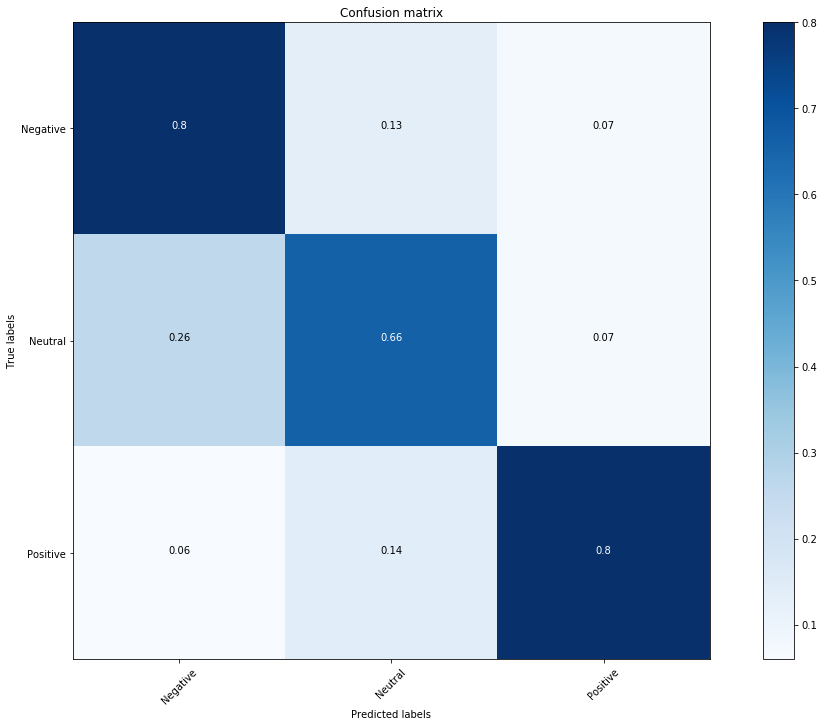

In [36]:
cmtx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cmtx, ['Negative', 'Neutral', 'Positive'], normalize=True)

## 5. Сабмишн

In [5]:
probs_dsts_fname = 'data/probs_dsts_test_x2_sized.npy'
weight_dsts = 0.6

probs_frames_fname = 'data/probs_frames_test.npy'
weight_frames = 0.86

probs_nn_fname = 'data/probs_nn_test_x2.npy'
weights_nn = [0.7, 0.7, 0.7, 0.7]

In [6]:
probs_dsts = np.load(probs_dsts_fname).item()
probs_nn = np.load(probs_nn_fname)
probs_frames = np.load(probs_frames_fname).item()

print len(probs_dsts), probs_nn.shape, len(probs_frames)

715 (4,) 770


In [7]:
predictions = {}

for fname in log_progress(probs_dsts.keys()):
    preds = np.zeros((3,))
    if probs_dsts[fname].max() < 3.6:
        preds += probs_dsts[fname] * weight_dsts
    else:
        preds += probs_dsts[fname] * weight_dsts / np.max(probs_dsts[fname])
    preds += probs_frames[fname] * weight_frames
    for tmp_probs, w in zip(probs_nn, weights_nn):
        preds += tmp_probs[fname] * w
    predictions[fname] = np.argmax(preds)
#     break

In [8]:
SUBMISSION_OUT_DIR = 'submission5'

Ручная разметка:

In [9]:
if not os.path.exists(SUBMISSION_OUT_DIR):
    os.makedirs(SUBMISSION_OUT_DIR)
    
for fname in log_progress(predictions.keys()):
    predicted = predictions[fname]
    fname = os.path.basename(fname)
    if fname == 'family-get-together-002.png':
        fname = 'family-get-together-002_1.png'
    fname = '.'.join(fname.split('.')[:-1])
    if fname == 'Prime_Minister_Narendra_Modi_with_French_President_FranЗois_Hollande_at_the_G20_Summit':
        fname = 'Prime_Minister_Narendra_Modi_with_French_President_Francis_Hollande_at_the_G20_Summit'
    f = open(os.path.join(SUBMISSION_OUT_DIR, fname + '.txt'), 'w')
    f.write('{}'.format(LBL2CLASS[predicted]))
    f.flush()
    f.close()

Нейросетевая разметка:

In [9]:
if not os.path.exists(SUBMISSION_OUT_DIR):
    os.makedirs(SUBMISSION_OUT_DIR)
    
for fname in log_progress(probs_frames.keys()):
    if predictions.get(fname, None) is None:
        predicted = np.argmax(probs_frames[fname])
    else:
        predicted = predictions[fname]
    fname = os.path.basename(fname)
    if fname == 'family-get-together-002.png':
        fname = 'family-get-together-002_1.png'
    fname = '.'.join(fname.split('.')[:-1])
    if fname == 'Prime_Minister_Narendra_Modi_with_French_President_FranЗois_Hollande_at_the_G20_Summit':
        fname = 'Prime_Minister_Narendra_Modi_with_French_President_Francis_Hollande_at_the_G20_Summit'
    f = open(os.path.join(SUBMISSION_OUT_DIR, fname + '.txt'), 'w')
    f.write('{}'.format(LBL2CLASS[predicted]))
    f.flush()
    f.close()

---

In [14]:
f = open('data/subm.list', 'w')
for fname in log_progress(predictions.keys()):
    f.write('{}\n'.format(os.path.basename(fname)))
f.flush()
f.close()